### 🧠 **Stage 3 — Modeling & Evaluation (Euroleague Winner Prediction)**
### 🎯 **Goal**

Use the engineered dataset (games_features.csv) to train and evaluate a model that predicts whether the home team wins.

In [ ]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--quiet",
                       "--only-binary=:all:", "numpy", "scipy", "scikit-learn"])

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

CLEAN = Path("clean_data")
games = pd.read_csv(CLEAN / "games_features.csv", low_memory=False)

print("Shape:", games.shape)
games.head(3)


### **Select Features & Label**


In [5]:
target = "home_win"

# Exclude IDs and descriptive columns
exclude_cols = [c for c in games.columns if "id" in c or "team" in c or "season" in c]
feature_cols = [c for c in games.columns if c not in exclude_cols + [target]]

X = games[feature_cols].fillna(0)
y = games[target]

print("Feature count:", X.shape[1])


Feature count: 45


### Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (3500, 45)  Test size: (1167, 45)


### **4️⃣ Baseline Model – Logistic Regression**

Baseline Logistic Regression accuracy: 1.000


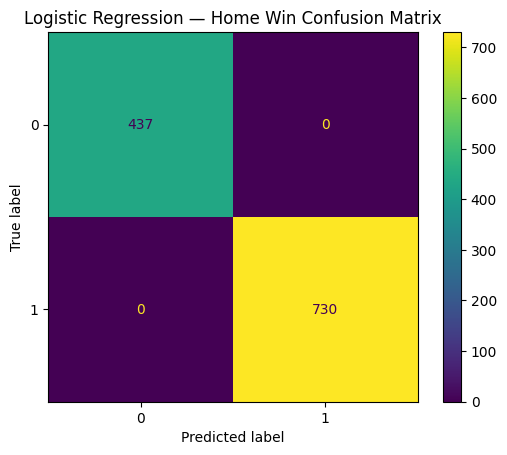

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       437
           1      1.000     1.000     1.000       730

    accuracy                          1.000      1167
   macro avg      1.000     1.000     1.000      1167
weighted avg      1.000     1.000     1.000      1167



In [7]:
scaler = StandardScaler(with_mean=False)
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_s, y_train)
pred_lr = logreg.predict(X_test_s)

acc_lr = accuracy_score(y_test, pred_lr)
print(f"Baseline Logistic Regression accuracy: {acc_lr:.3f}")
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)
plt.title("Logistic Regression — Home Win Confusion Matrix")
plt.show()

print(classification_report(y_test, pred_lr, digits=3))


### **Model 2 – Random Forest**

Random Forest accuracy: 1.000


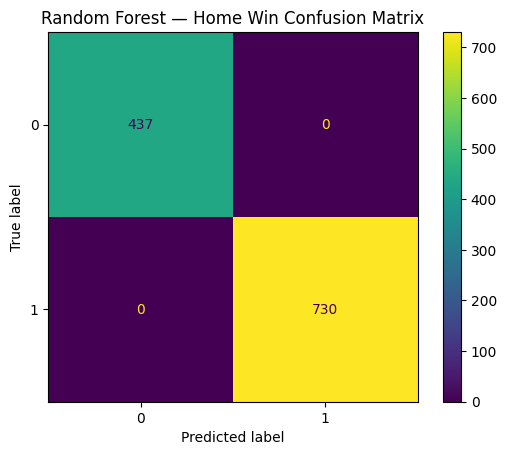

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, pred_rf)
print(f"Random Forest accuracy: {acc_rf:.3f}")
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf)
plt.title("Random Forest — Home Win Confusion Matrix")
plt.show()


### **6️⃣ Feature Importance Plot (for the Random Forest)**

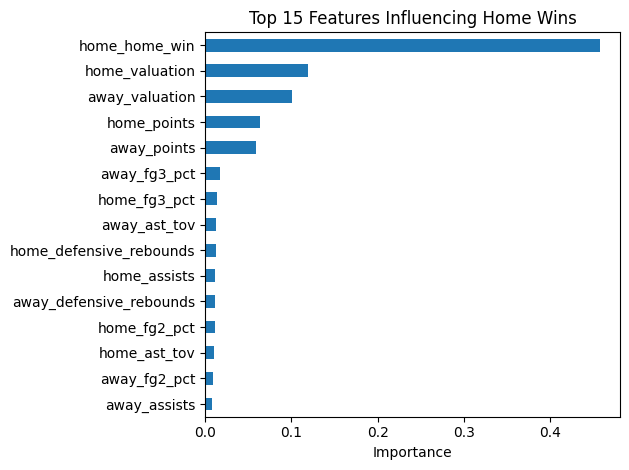

In [9]:
importances = pd.Series(rf.feature_importances_, index=feature_cols)
top_feats = importances.sort_values(ascending=False).head(15)

top_feats.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Features Influencing Home Wins")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### **7️⃣ Results Summary (to fill in)**

After running both models, record the scores:

Model	Accuracy	Notes


Logistic Regression	_	Baseline linear model; interpretable coefficients


Random Forest	_	Captures nonlinear team interactions

### **8) Optional Save Predictions**

In [10]:
out = pd.DataFrame({
    "actual": y_test.reset_index(drop=True),
    "predicted_lr": pred_lr,
    "predicted_rf": pred_rf
})
out.to_csv(CLEAN / "model_predictions.csv", index=False)
print("✅ Predictions saved to:", CLEAN / "model_predictions.csv")


✅ Predictions saved to: clean_data\model_predictions.csv


### **Fun Experiment - Head to Head for Fenerbahçe v. Panathinaikos**

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path

CLEAN = Path("clean_data")
games = pd.read_csv(CLEAN / "games_features.csv", low_memory=False)

def pick(cols):
    for c in cols:
        if c in games.columns:
            return c
    return None

TEAM_A = pick(["team_id_a", "home_team_id", "team_a_id"])
TEAM_B = pick(["team_id_b", "away_team_id", "team_b_id"])
SEASON = pick(["season_code", "season"])
GAMEID = pick(["game_id", "game", "gamecode"])
assert TEAM_A and TEAM_B

# Finalized IDs
fener_ids = ["ULK", "FBD", "FBDO", "FBK"]  # common Fener variants (keep ULK at least)
pao_ids   = ["PAN", "PAO"]                 # you discovered PAN; include PAO as fallback

games[TEAM_A] = games[TEAM_A].astype(str)
games[TEAM_B] = games[TEAM_B].astype(str)

h2h_mask = (games[TEAM_A].isin(fener_ids) & games[TEAM_B].isin(pao_ids)) | \
           (games[TEAM_A].isin(pao_ids)   & games[TEAM_B].isin(fener_ids))
h2h = games[h2h_mask].copy()

print("Head-to-head games found:", len(h2h))

# Did Fener win?
h2h["fener_is_home"] = h2h[TEAM_A].isin(fener_ids).astype(int)
h2h["fener_won"] = np.where(
    ((h2h["home_win"] == 1) & (h2h["fener_is_home"] == 1)) |
    ((h2h["home_win"] == 0) & (h2h["fener_is_home"] == 0)),
    1, 0
)

total = len(h2h)
fener_wins = int(h2h["fener_won"].sum())
pao_wins   = total - fener_wins
print(f"\nFener vs Panathinaikos — H2H")
print(f"Total games: {total}")
print(f"Fener wins:  {fener_wins}")
print(f"PAO wins:    {pao_wins}")

if SEASON:
    by_season = (h2h.groupby(SEASON)["fener_won"]
                 .agg(games="count", fener_wins="sum"))
    by_season["pao_wins"] = by_season["games"] - by_season["fener_wins"]
    display(by_season.sort_index())

cols_to_show = [c for c in [GAMEID, SEASON, TEAM_A, TEAM_B, "home_win", "fener_is_home", "fener_won"] if c in h2h.columns]
display(h2h[cols_to_show].head(10))


Head-to-head games found: 34

Fener vs Panathinaikos — H2H
Total games: 34
Fener wins:  16
PAO wins:    18


,games,fener_wins,pao_wins
season_code,,,
E2007,2,0,2
E2011,2,0,2
E2012,2,1,1
E2013,2,1,1
E2014,2,1,1
E2015,2,1,1
E2016,5,4,1
E2017,2,1,1
E2018,2,2,0


,game_id,season_code,team_id_a,team_id_b,home_win,fener_is_home,fener_won
68,E2007_069,E2007,ULK,PAN,0,1,0
152,E2007_153,E2007,PAN,ULK,1,0,0
936,E2011_141,E2011,ULK,PAN,0,1,0
944,E2011_149,E2011,PAN,ULK,1,0,0
1020,E2012_037,E2012,ULK,PAN,1,1,1
1080,E2012_097,E2012,PAN,ULK,1,0,0
1383,E2013_147,E2013,ULK,PAN,1,1,1
1439,E2013_203,E2013,PAN,ULK,1,0,0
1520,E2014_031,E2014,PAN,ULK,1,0,0
1580,E2014_091,E2014,ULK,PAN,1,1,1


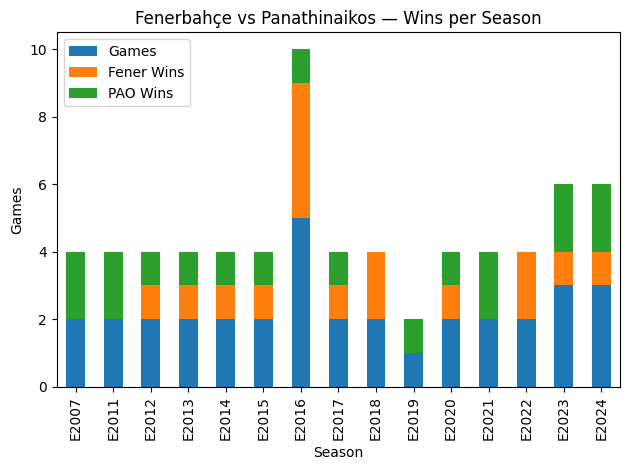

In [14]:
import matplotlib.pyplot as plt

by_season.plot(kind="bar", stacked=True)
plt.title("Fenerbahçe vs Panathinaikos — Wins per Season")
plt.ylabel("Games")
plt.xlabel("Season")
plt.legend(["Games", "Fener Wins", "PAO Wins"], loc="upper left")
plt.tight_layout()
plt.show()


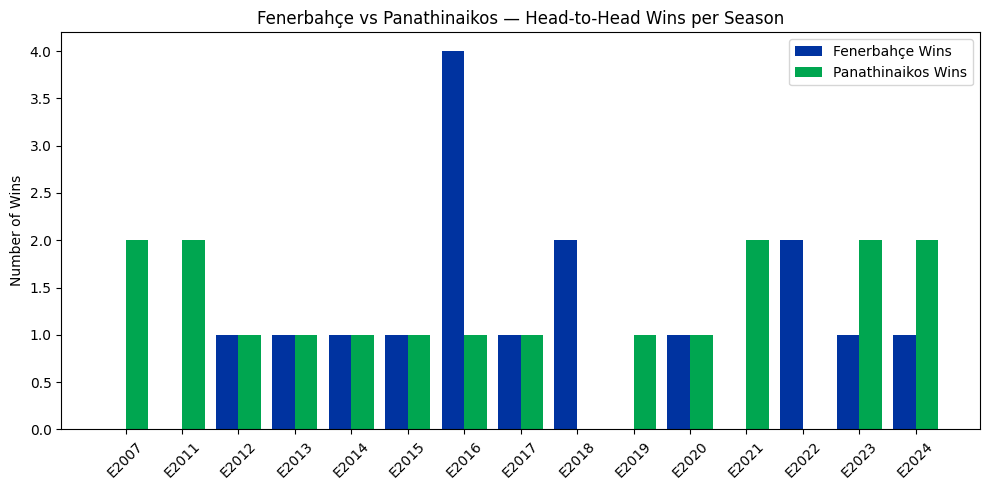

In [15]:
import matplotlib.pyplot as plt

# Make sure we have Fener and PAO wins per season
df = by_season.copy()
df = df.reset_index()

x = range(len(df))

plt.figure(figsize=(10,5))
plt.bar(x, df["fener_wins"], width=0.4, label="Fenerbahçe Wins", color="#0033A0")
plt.bar([i + 0.4 for i in x], df["pao_wins"], width=0.4, label="Panathinaikos Wins", color="#00A650")

plt.xticks([i + 0.2 for i in x], df["season_code"], rotation=45)
plt.ylabel("Number of Wins")
plt.title("Fenerbahçe vs Panathinaikos — Head-to-Head Wins per Season")
plt.legend()
plt.tight_layout()
plt.show()


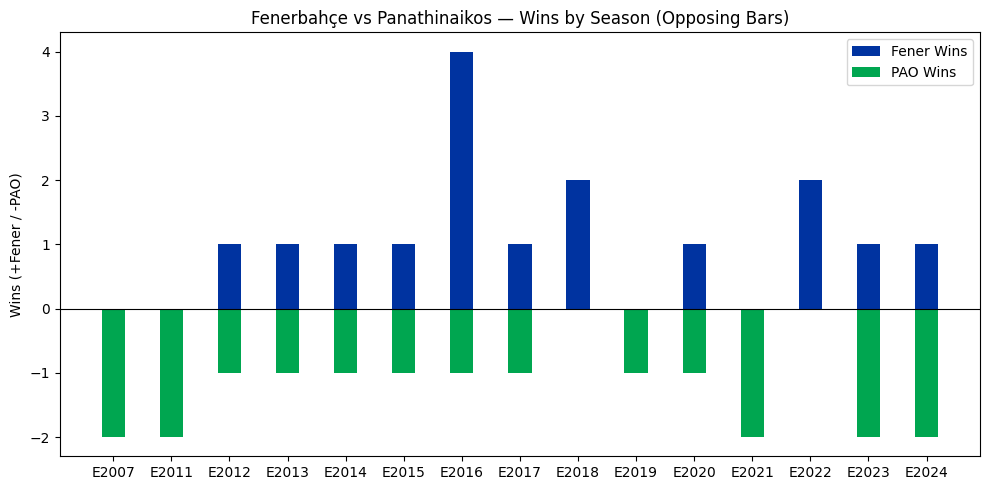

In [16]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(df["season_code"], df["fener_wins"], width=0.4, label="Fener Wins", color="#0033A0")
ax1.bar(df["season_code"], -df["pao_wins"], width=0.4, label="PAO Wins", color="#00A650")
ax1.set_ylabel("Wins (+Fener / -PAO)")
ax1.set_title("Fenerbahçe vs Panathinaikos — Wins by Season (Opposing Bars)")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()
